## Introduction

The following analysis has the purpose of studying the characteristics of the customers of Blackwell Electronics. For this purpose various techniques of data analysis will be used, cenetered around an Exploratory Data Analysis of the data set, showing graphics and statistical measurements to explain certain behaviours. The main questions that will be studied in the analysis are the following:<br>
<ul>
<li>Do customers in different regions spend more per transaction?</li>
<li>Which regions spend the most/least?</li>
<li>Is there a relationship between number of items purchased and amount spent?</li>
</ul>
Additionally further insights about the data will be studied and explained to provide a wider understanding about the customers.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

## Reading Data Set with Pandas

In [2]:
data = pd.read_csv('Demographic_Data.csv')
data.head()
#Importing data and doing an initial visualization

,in-store,age,items,amount,region
0,0,37,4,281.03,2
1,0,35,2,219.51,2
2,1,45,3,1525.70,4
3,1,46,3,715.25,3
4,1,33,4,1937.50,1


## Analysis


## Pre-Processing

In [3]:
data.describe()

,in-store,age,items,amount,region
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.500000,45.757925,4.504975,835.919670,2.675000
std,0.500003,15.715679,2.061238,721.273736,1.126672
min,0.000000,18.000000,1.000000,5.004700,1.000000
25%,0.000000,33.000000,3.000000,285.140000,2.000000
50%,0.500000,45.000000,4.000000,582.315000,3.000000
75%,1.000000,56.000000,6.000000,1233.700000,4.000000
max,1.000000,85.000000,8.000000,3000.000000,4.000000


Initially some sense of the data is obtained.

In [4]:
#basic info about the data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   in-store  80000 non-null  int64  
 1   age       80000 non-null  int64  
 2   items     80000 non-null  int64  
 3   amount    80000 non-null  float64
 4   region    80000 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 3.1 MB


The data types of all the data is obtained. Note that although 'in-store' and 'region' are numeric times, they are actually cathegorical variables.

In [5]:
#Duplicated values
print("Duplicate values:\t",data.duplicated().sum())

Duplicate values:	 21


The data is checked for duplicates. Since the number of duplicated data is small relative to the sample size, and given there is no way to check if the data is truly duplicated or simply different orders with the same characteristics, this records will be kept.

In [6]:
#Null values
print("Null values:\n",data.isnull().sum())

Null values:
 in-store    0
age         0
items       0
amount      0
region      0
dtype: int64


The data contains is searched for null values but there are none.

In [7]:
#Invalid values
print("Invalid 'in-store' values:\t",((data['in-store'] != 0) & (data['in-store'] != 1)).sum())
print("Invalid 'age' values:\t\t",((data['age'] <= 0) | (data['age'] > 200)).sum())
print("Invalid 'items' values:\t\t",((data['items'] <= 0)).sum())
print("Invalid 'amount' values:\t",((data['amount'] <= 0)).sum())
print("Invalid 'region' values:\t",((data['region'] != 1) & (data['region'] != 2) & (data['region'] != 3) & (data['region'] != 4)).sum())

Invalid 'in-store' values:	 0
Invalid 'age' values:		 0
Invalid 'items' values:		 0
Invalid 'amount' values:	 0
Invalid 'region' values:	 0


The data is checked for invalid values (negative or null ages, prices or quantities and invalid values of cathegorical variables), but it does not contain any.

In [8]:
#Outliers
## 'age' outliers
iq_age = data.quantile(.75)['age'] - data.quantile(.25)['age']
age_out = data.loc[(((data['age'] < data.quantile(.25)['age'] - iq_age*1.5) | (data['age'] > data.quantile(.75)['age'] + iq_age*1.5)) == True)]
print("Outliers in 'age':\t",age_out.size/5)
## 'items' outliers
iq_items = data.quantile(.75)['items'] - data.quantile(.25)['items']
items_out = data.loc[(((data['items'] < data.quantile(.25)['items'] - iq_items*1.5) | (data['items'] > data.quantile(.75)['items'] + iq_items*1.5)) == True)]
print("Outliers in 'items':\t",items_out.size/5)
## 'amount' outliers
iq_amount = data.quantile(.75)['amount'] - data.quantile(.25)['amount']
amount_out = data.loc[(((data['amount'] < data.quantile(.25)['amount'] - iq_amount*1.5) | (data['amount'] > data.quantile(.75)['amount'] + iq_amount*1.5)) == True)]
print("Outliers in 'amount':\t",amount_out['amount'].count())

Outliers in 'age':	 0.0
Outliers in 'items':	 0.0
Outliers in 'amount':	 2318


The only quantity that presents outliers is the amount payed in the order. Still given that in an electronic store the prices can range from thousands of dollars (a computer) to very small prices (a mouse pad), directly excluding them would leave an important part of the data out of the analysis. Still they will be kept stored in case that some future analysis could benefit from excluding these values.

In [9]:
#Number of decimals in amount
print("Values of 'amount' with more than two decimals:\t",data.loc[((data.amount*100).apply(np.floor))/100 != data.amount]['amount'].size)

Values of 'amount' with more than two decimals:	 9012


Normally currency values only contain two decimal ciphers. The cause of this abnormal values is most likely related with the VAT and the way the values are stored, probably before applying the tax. Since this additional impact represent an infimum difference compared with the magnitude of the values, they will not be rounded off, as their impact in the analysis will be negligible.

## Exploratory Data Analysis

### Regional analysis

The main purpose of this section is finding the answer of the following questions:<br>
<ul>
<li>Do customers in different regions spend more per transaction?</li>
<li>Which regions spend the most/least?</li>
</ul>
To address the first question, the distribution of the amount spent in each transaction will be analyzed for each region.

In [10]:
#Check the amount of orders per region
data.groupby('region').size()

region
1    16000
2    20000
3    18000
4    26000
dtype: int64

[]

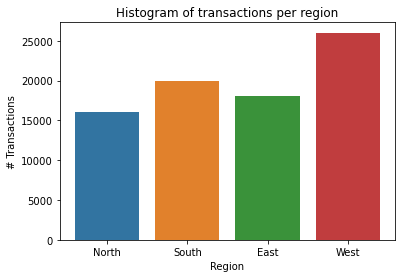

In [11]:
#Plot the number of orders per region
plot = sns.countplot(x = "region",data=data)
plot.set_xticklabels(['North','South','East','West'])
plot.set_title('Histogram of transactions per region')
plot.set_ylabel('# Transactions')
plot.set_xlabel('Region')
plot.plot()

<i>Figure 1. Histogram showing the amount of transactions in each region.</i>

It is noticeable that the West region has an higher amount of orders. Now the distribution of the amount spent is checked.

In [12]:
#Get number of transactions in each region
data.groupby('region').mean()['amount']

region
1     745.161491
2     252.109196
3     917.969637
4    1284.052012
Name: amount, dtype: float64

The means of the regions show that indeed there are differences in the amount per transaction spent in each region. Notice for example that region 2 (South) has the lowest mean while the previous graphic showed it is the recond with the second highest number of transactions. However, a more in depth analysis of the amount distribution would be helpful to get more precise conclussions.

[]

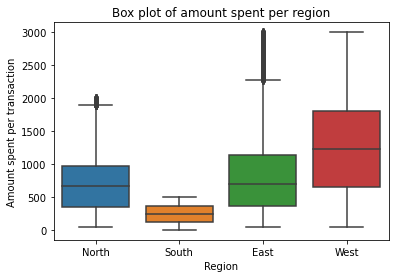

In [13]:
#Plot a box plot of the amount spent in each region
plot = sns.boxplot(x='region', y='amount', data = data)
plot.set_xticklabels(['North','South','East','West'])
plot.set_title('Box plot of amount spent per region')
plot.set_ylabel('Amount spent per transaction')
plot.set_xlabel('Region')
plot.plot()

<i>Figure 2. Box plot showing the distribution of the amount spent in transactions at each region.</i>

This graphic shows that there is a high amount of outliers in the East region and some of them in the Northern one. Also, the data in the West region is very distributed, so further analysis is required to draw reliable conclusions about these regions. Still, in the case of the Southern region the data is very concentrated around small values, so for now it can be assumed that this region spends less per transaction that the rest of them.

Text(0, 0.5, '# Transactions')

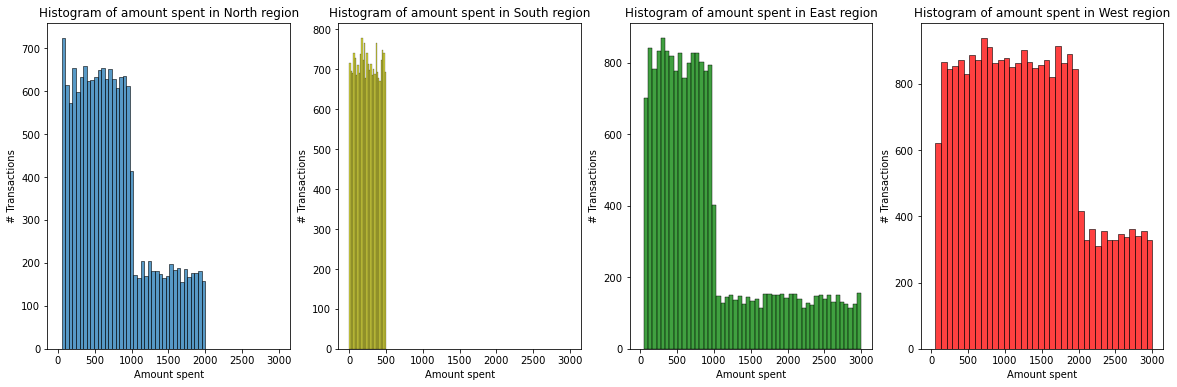

In [14]:
#Plot histograms of amount spent per transaction in each region
fig , axes = plt.subplots(1,4,figsize = (20,6), sharex=True)
sns.histplot(x="amount",data=data.groupby('region').get_group(1),ax=axes[0])
axes[0].title.set_text("Histogram of amount spent in North region")
axes[0].set_xlabel('Amount spent')
axes[0].set_ylabel('# Transactions')
sns.histplot(x="amount",data=data.groupby('region').get_group(2),ax=axes[1], color = 'y')
axes[1].title.set_text("Histogram of amount spent in South region")
axes[1].set_xlabel('Amount spent')
axes[1].set_ylabel('# Transactions')
sns.histplot(x="amount",data=data.groupby('region').get_group(3),ax=axes[2], color = 'g')
axes[2].title.set_text("Histogram of amount spent in East region")
axes[2].set_xlabel('Amount spent')
axes[2].set_ylabel('# Transactions')
sns.histplot(x="amount",data=data.groupby('region').get_group(4),ax=axes[3], color = 'r')
axes[3].title.set_text("Histogram of amount spent in West region")
axes[3].set_xlabel('Amount spent')
axes[3].set_ylabel('# Transactions')

<i>Figures 3-6. Histograms showing the distribution of the amount spent in transactions in each region.</i>

As it can be seen in the graphs, the South region spents the least per order in general, and all of its transactions are of small cost. In contrast, the West region spents the same or more in almost all of the price ranges (with the exception of the cheapest section for which there are more transactions in other regions). The North and East regions show similar buying patterns for the lower and intermediate price ranges, although there are transactions of high prices in East while there are none in the North.


<b>Do customers in different regions spend more per transaction?</b><br>
Yes, the South region spends the least per transaction while the West region spends the most. The North and East regions spend intermediately, with the East being ahead due to having high amount transactions. The main factor positioning the West as the main spender is the high number of intermediate priced transactions (1000-2000) in the region, whereas other regions have few or no transaction in that range. Improving transactions of that price range in other regions would cause a high impact in the total spending.

Answering the second question is more complex beacuse there are various answers to it. It has already been determined that in average, the West region spends the most and the South spends the least. However, analysing the total amount spent per region could be another way of answering the question and also gives important information.

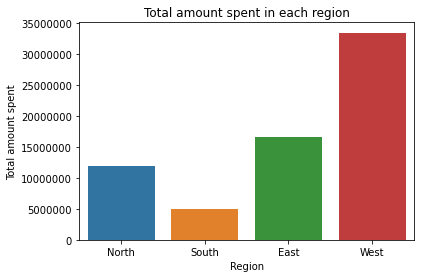

In [15]:
#Plot total amount spent in each region
plot = sns.barplot(x = 'region', y = 'amount',data = data.groupby('region').sum().reset_index())
plot.set_xticklabels(['North','South','East','West'])
plot.set_title("Total amount spent in each region")
plot.set_xlabel('Region')
plot.set_ylabel('Total amount spent')
plot.ticklabel_format(style='plain', axis='y')

<i>Figure 7. Total amount spent in each region</i>

<b>Which regions spend the most/least?</b><br>
After analyzing the total amount spent in each region, the conclusions obtained are the same as with the amount per transaction: again, the West spent the most, followed by the East and the North which spend signifcantly less. The South region is again the one spending the least.

Apart of answering this questions, analyzing how the purchases are done in each region could yield relevant information:

[]

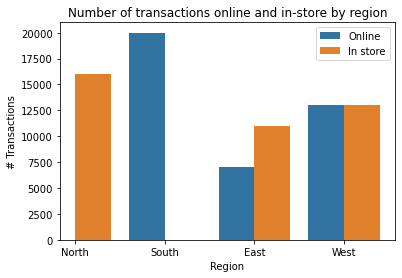

In [16]:
#Plot number of transactions online and in-store at each region
plot = sns.countplot(data = data, x = 'region', hue = 'in-store')
plot.set_xticklabels(['North','South','East','West'])
plot.legend(['Online','In store'])
plot.set_xlabel('Region')
plot.set_ylabel('# Transactions')
plot.set_title('Number of transactions online and in-store by region')
plot.plot()

<i>Figure 8. Bar plot showing the number of transactions online and in physical stores in each region.</i>

It is noticeable that the North region has no online transactions while the South has no transactions in physical stores. A possible explanation could be the South region having no stores and the online store being unavailable in the North. Opening this possibilities for these regions could be a way of increasing the profits generated there.

### Item quantity analysis

To answer the question about the possible relation between the number of items and the amount spent, an initial assumption will be done and the analysis will be centerend about confirming or disproving it. In this case, assuming that there exists some relationship between the number of items and the amount spent in an order makes sense, since one could think that buying more products would mean spending more money.<br>
Initially, the distribution of the amount spent is checked:

Text(-2.700000000000003, 0.5, '# Transactions')

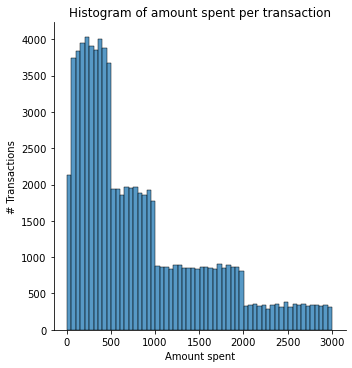

In [17]:
#Plot histogram of amount spent
plot = sns.displot(x='amount',data=data,binwidth = 50)
plot.axes[0][0].set_title('Histogram of amount spent per transaction')
plot.axes[0][0].set_xlabel('Amount spent')
plot.axes[0][0].set_ylabel('# Transactions')

<i>Figure 9. Histogram showing the distribution of the amount spent in each transaction.</i>

The frequency of the transaction decreases as the amount spent decreases. Some amount blocks can be appreciated and could be used in further analysis.

Now, if the initial assumption of a relationship between the number of items and the amount spent is true, then it could be expected that the number of bought items would follow a similar distribution.

Text(-9.075000000000003, 0.5, '# Transactions')

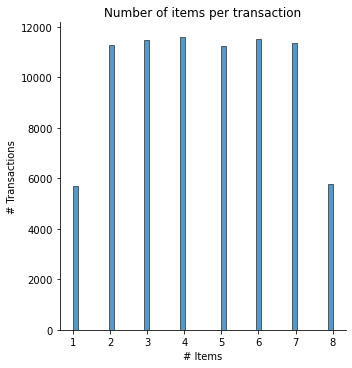

In [18]:
#Plot histogram of number of items per transaction
plot = sns.displot(x='items',data=data)
plot.axes[0][0].set_title('Number of items per transaction')
plot.axes[0][0].set_xlabel('# Items')
plot.axes[0][0].set_ylabel('# Transactions')

<i>Figure 10. Histogram showing the distribution of the number of items in each transaction.</i>

However, the distribution of the number of bought items is a lot different to that of the spent amount, which casts doubts on the initial hypothesis. To definitely confirm it, the distribution of the amount spent for each number of items can be analysed.

Text(0, 0.5, 'Amount spent')

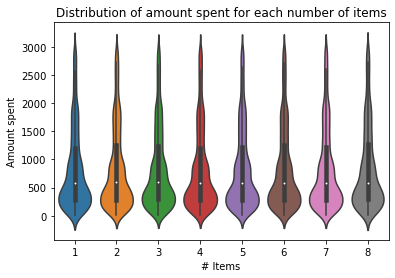

In [19]:
#Plot violin plots of amount spent for each number of items
plot = sns.violinplot(x="items", y="amount",kind = 'violin',data=data,size = (10,6))
plot.set_title('Distribution of amount spent for each number of items')
plot.set_xlabel('# Items')
plot.set_ylabel('Amount spent')

<i>Figure 11. Violin plot showing the distribution of the amount spent in each transaction for each number of items.</i>

In the above graphs it can be seen that for any number of items the amount spent follows almost the exact same distribution, so it can be safely concluded that there is no relationship between the number of items and the amount spent per transaction. To check it mathematically, the Pearson correlation coefficient can be calculated.

In [20]:
#Calculate correlation coefficient
print("The correlation between the number of items and the amount spent is ",data.corr()['items']['amount'])

The correlation between the number of items and the amount spent is  0.0003670028707839606


The correlation is almost 0, which fits with the conclussion of the two magnitudes not being related.

A possible explanation for this behaviour could be that orders with higher number of items include products of smaller price.

In [21]:
#Add average price per item to the dataset
avg_per_item=data['amount']/data['items']
avg_per_item = avg_per_item.rename("average")
data = data.join(avg_per_item)
data.head()

,in-store,age,items,amount,region,average
0,0,37,4,281.03,2,70.257500
1,0,35,2,219.51,2,109.755000
2,1,45,3,1525.70,4,508.566667
3,1,46,3,715.25,3,238.416667
4,1,33,4,1937.50,1,484.375000


Text(0, 0.5, 'Average price of items')

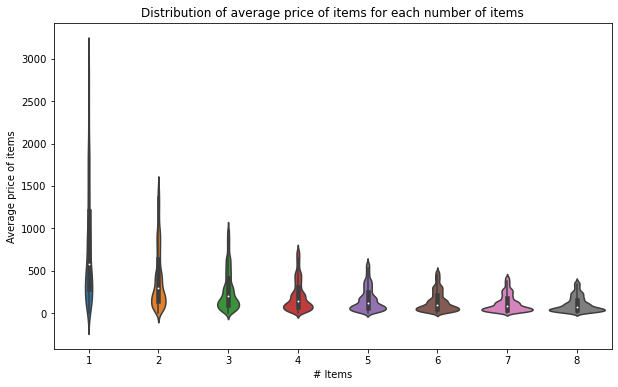

In [22]:
#Plot violin plot of average price per item for each number of items 
fig , axes = plt.subplots(1,1,figsize = (10,6), sharex=True)
sns.violinplot(x="items", y="average",kind = 'violin',data=data,ax = axes)
axes.set_title("Distribution of average price of items for each number of items")
axes.set_xlabel('# Items')
axes.set_ylabel('Average price of items')

<i>Figure 12. Violin plot showing the distribution of the average price of items for each number of items.</i>

The graphic shows that indeed, orders with a higher number of items have amounts more concentrated around low prices while orders with less items have more variated values. This could be explained with the fact that electronic stores sell a big range of products, from high priced devices to cheaper products like accesories. Orders with many items could come from accesories sales while transactions with fewer products would refer to orders of products of higher value.

<b>Is there a relationship between the number of items purchased and amount spent?</b><br>
No, there is no relationship between the number of items and the amount spent per transaction and for any number of items, the amount spent follows similar distributions. This is highly likely due to orders with more items being of products of less value.

## Additional analysis and insights

<b>Decimal places</b><br>
As explained in the pre-processing, there exist some values of the amount spent in each order that are stored with more than two decimal places. In general, all values have been check to have 5 significant digits, which probably comes from the software used to gather the data. As mentioned previously, a possible cause for the abnormal decimals could be that the values are stored before applying VAT.

<b>Age</b><br>
The questions asked by Ms Sherman did not include an analysis of the impact of the age of the clients, which could provide important data.

First, an study of the distribution of the age in each region will be performed:

Text(0, 0.5, '# Transactions')

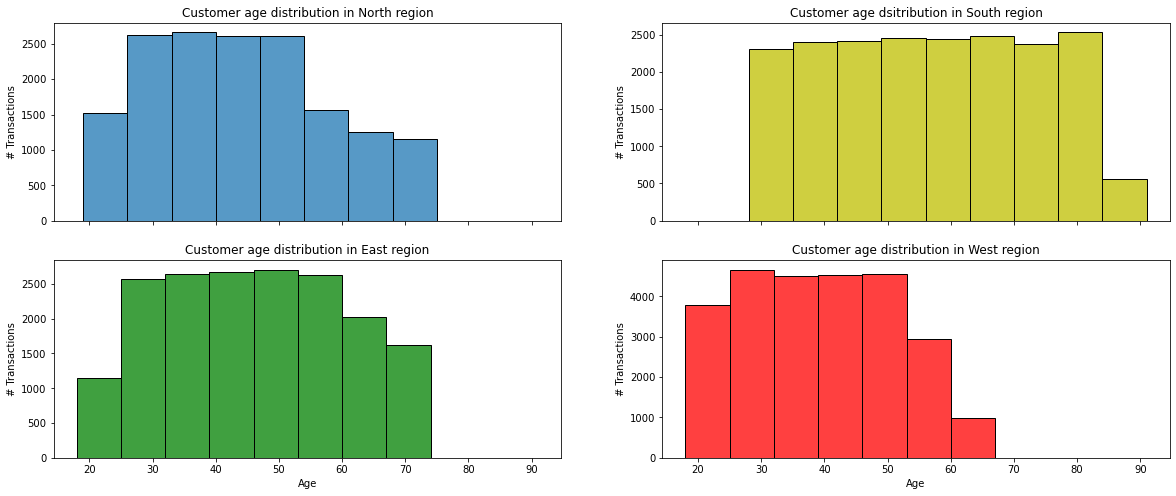

In [23]:
#Plot histograms of customers' age at each region
fig , axes = plt.subplots(2,2,figsize = (20,8), sharex=True)
sns.histplot(x="age",data=data.groupby('region').get_group(1),ax=axes[0][0],binwidth = 7)
axes[0][0].title.set_text("Customer age distribution in North region")
axes[0][0].set_xlabel('Age')
axes[0][0].set_ylabel('# Transactions')
sns.histplot(x="age",data=data.groupby('region').get_group(2),ax=axes[0][1],binwidth = 7, color = 'y')
axes[0][1].title.set_text("Customer age dsitribution in South region")
axes[0][1].set_xlabel('Age')
axes[0][1].set_ylabel('# Transactions')
sns.histplot(x="age",data=data.groupby('region').get_group(3),ax=axes[1][0],binwidth = 7, color = 'g')
axes[1][0].title.set_text("Customer age distribution in East region")
axes[1][0].set_xlabel('Age')
axes[1][0].set_ylabel('# Transactions')
sns.histplot(x="age",data=data.groupby('region').get_group(4),ax=axes[1][1],binwidth = 7, color = 'r')
axes[1][1].title.set_text("Customer age distribution in West region")
axes[1][1].set_xlabel('Age')
axes[1][1].set_ylabel('# Transactions')

<i>Figures 13-16. Histogram showing the distrubution of the customers' age in each region.</i>

There are some clear differences in the age demography between regions:
<ul>
    <li>In general, the number of customers between 18 and 25 years is sensibly smaller than the quantity of middle-aged clients in all regions except for the West. This is specially noticeable in the South which have no clients of this age range at all.</li>
    <li>The core of the clients is middle-aged, which is common in most businesses.</li>
    <li>In older age ranges, the North and the West start losing clients around the 53 years, while the East maintains the same quantity until the 60 years. The South is the only region with as many older clients as middle-aged ones, even having a small number of clients older than 84.</li>
</ul>

After that, the method of purchase is studied for different age ranges:

In [24]:
#Create age group entry
less_37 = (data['age']<=37).apply(int)
btw_38_52 = ((data['age']>37) & (data['age']<=52)).apply(int)*2
more_52 = (data['age'] > 52).apply(int)*3
age_range = less_37 + btw_38_52 + more_52
data = data.join(age_range.rename('age group'))

Text(0.5, 1.0, 'Number of transaction in-store and on-line by age group')

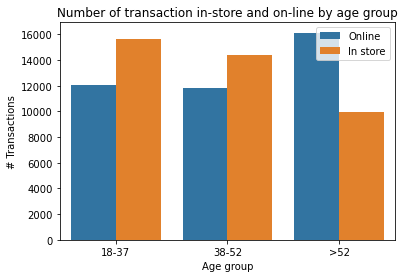

In [25]:
#Plot number of transactions online and in-store for each age group
plot = sns.countplot(data=data,x='age group', hue = 'in-store')
plot.set_xticklabels(['18-37','38-52','>52'])
plot.set_xlabel('Age group')
plot.set_ylabel('# Transactions')
plot.legend(['Online','In store'])
plot.set_title('Number of transaction in-store and on-line by age group')

<i>Figure 17. Bar plot showing the amount of transactions online and in physical stores by age group.</i>

As the age of the customers increases, the online purchases increase while the sales in stores go down. This results fit with previous observations, shuch as the South region, which has the biggest number of older consumers only having online transactions.

Text(0.5, 1.0, 'Histogram of amount spent by customers of more than 52 years')

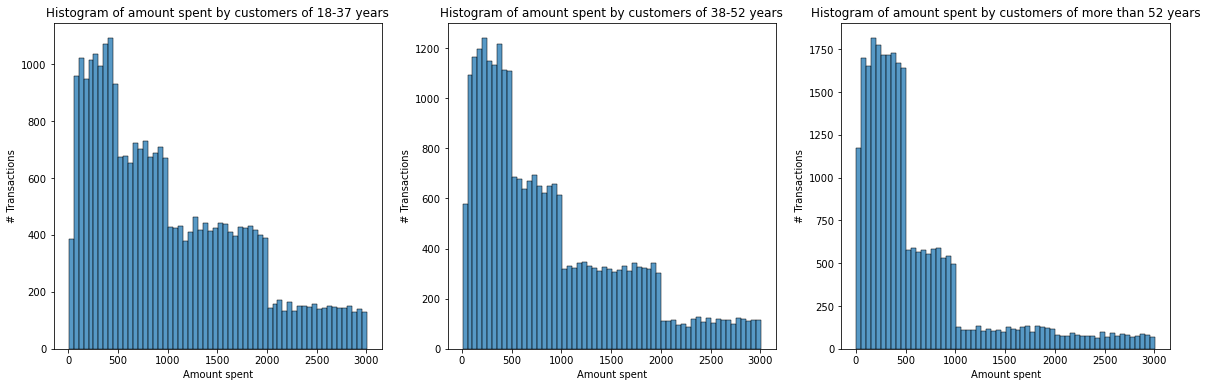

In [26]:
#Plot histograms of amount spent at each age group
plot, axes = plt.subplots(1,3,sharex = True,figsize = (20,6))
sns.histplot(data=data.groupby('age group').get_group(1), x = 'amount',binwidth = 50, ax = axes[0])
axes[0].set_xlabel('Amount spent')
axes[0].set_ylabel('# Transactions')
axes[0].set_title('Histogram of amount spent by customers of 18-37 years')
sns.histplot(data=data.groupby('age group').get_group(2), x = 'amount',binwidth = 50, ax = axes[1])
axes[1].set_xlabel('Amount spent')
axes[1].set_ylabel('# Transactions')
axes[1].set_title('Histogram of amount spent by customers of 38-52 years')
sns.histplot(data=data.groupby('age group').get_group(3), x = 'amount',binwidth = 50, ax = axes[2])
axes[2].set_xlabel('Amount spent')
axes[2].set_ylabel('# Transactions')
axes[2].set_title('Histogram of amount spent by customers of more than 52 years')

<i>Figures 18-20. Histograms showing the distribution of the amount spent by each age group.</i>

It is noticeable in the above graphics that the oldest age group has a lower amount of transactions in the middle-priced amounts, concretely in the range 500-2000. This is even more remarkable if the plots are compared with figure 8, which shows the distribution of the amount per transaction of the whole data set. The first two groups are distributed similarly to the sample as a whole while the oldest group has less transaction of intermediate prices.

## Conclusions

After the analysis performed, the insights obtained about the data set can be summarized in the following points:
<ul>
    <li><b>Do customers in different regions spend more per transaction?</b></li>
    Yes, customers in the West region tend to spend the most followed by the East and the North, with South being the region expending the least. The main difference between the West and the rest of the regions is a high number of purchases in a price range of 1000 to 2000, with the rest of the regions having a fewer transactions or none in that range. Increasing the sales of amounts in these range of prices in other regions could be a way of improving the profits there. The South is the least spender by far due to its purchases being concentrated only in a cheap range.
    <li><b>Which regions spend the most/least?</b></li>
    Again, the West is the biggest spender by a wide difference, followed by the East and the North, with the South being at the tail. This behaviour can be explained by the same causes as the previous question.
    <li><b>Additional insights regarding the regional distribution</b></li>
        There are noticeable differences in the way the purchases are done in each region. The most remarkable one is the South region only having online purchases and the clients from the North only buying in physical stores. These behaviours could be explained with South region not having physical stores and the online services being unavailable in the North. Giving access to these services in the corresponding regions could increase the profits obtained from them.
    <li><b>Is there a relationship between number of items purchased and amount spent?</b></li>
    No, there is no relation between the number of items purchased and the amount spent. For any number of items purchased, the amount spent in the transaction is equally distributed. This comes from the fact that transactions with higher number of items tend to contain products of lower value. A possible explanation for this behaviour could come from the fact that electronic stores sell a big range of products, from high priced devices to cheaper products like accesories and orders with many items could come from accesories sales while transactions with fewer products would refer to orders of products of higher value.
    <li><b>Additional insights regarding the age of customers</b></li>
    The main group of customers is between 25 and 55 years old, which is common in most businesses as this is the range of population that consumes the most. However, there exist differences in the distribution of the customers' age between regions.<br>
    The West has the highest amount of young customers (18-25 years old), while other regions having less customers of that ages and the South region having none at all. Regarding older customers, the North and the West start losing customers around the 53 years, while the East maintains the same quantity until the 60 years. The South is the only region with as many older clients as middle-aged ones, even having a small number of clients older than 84. <br>
    About the method of purchasing, younger age groups tend to buy more in physical stores while older groups prefer online purchases. This fits with other observations, like the South region having only online purchases and the highest number of old clients.<br>
    Regarding the spending habits of each age group, the only group with a different behaviour are the customers older than 52, who did sensibly less orders of the amount range of 500 to 2000. Fomenting purchases of that amount range to that age group could increase the profit they generate.
</ul>